In [2]:
import numpy as np
import math
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

random_seed = 42

/root/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
train_df = pd.read_csv('../input/train.tsv', sep='\t')
test_df = pd.read_csv('../input/test.tsv', sep='\t')

train_df = train_df.sample(frac=0.001)
train_df.info()
print ("=======================")
test_df.info()

print ("~~~~~~~~~~~~~~~~~~~~~~~")
train_df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1483 entries, 1335773 to 1195659
Data columns (total 8 columns):
train_id             1483 non-null int64
name                 1483 non-null object
item_condition_id    1483 non-null int64
category_name        1481 non-null object
brand_name           826 non-null object
price                1483 non-null float64
shipping             1483 non-null int64
item_description     1483 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 104.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB
~~~~~~~~~~~~~~~~~~~~~~

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1335773,1335773,Original Nintendo with 2 Controllers,3,Electronics/Video Games & Consoles/Consoles,NaN,85.0,1,"Original Nintendo with 2 Controllers, Light Gu..."
655848,655848,Black Reebok Workout Tank Top Size Small,2,Women/Athletic Apparel/Shirts & Tops,Reebok,9.0,0,"In great condition, no flaws! Great running ta..."
792106,792106,Vineyard Vines long sleeve T shirt!,2,Women/Tops & Blouses/T-Shirts,vineyard vines,20.0,0,This is a girls Large long sleeve T shirt!!! I...
1386810,1386810,Lularoe os black background peacocks,2,Women/Jeans/Leggings,NaN,36.0,1,Lularoe size OS black background blue peacocks...
755886,755886,Vape tshirt,3,Men/Tops/T-shirts,NaN,11.0,0,Vape boss social club tshirt. Unisex
348685,348685,Make up kit,1,Beauty/Makeup/Makeup Sets,NaN,5.0,1,"Makeup kit with eye lashes, red lipstick, eye ..."
41897,41897,Navy Blue Curtains,2,Home/Home Décor/Window Treatments,Target,26.0,0,4 panels. Great condition. No longer have a us...
219209,219209,Pokémon Charizard (Hold),2,Kids/Toys/Hobbies,Pokemon,34.0,0,"Holo, rare, mint condition"
129718,129718,Brandy Melville Cardigan,2,Women/Sweaters/Cardigan,Brandy Melville,26.0,0,I had the same cardigan and thought I lost it ...
264985,264985,Josie Maran Argan Oil Body Butter qty 2,1,Beauty/Bath & Body/Scrubs & Body Treatments,NaN,31.0,0,Scent : lavender citrus and The Second one is ...


* train_id / test_id: A unique key for each item.
* name: The item's name as a string.
* item_condition_id: A factor with 5 levels. As the plot below shows, the mean prices for different conditions are really close and it's hard to guess which whether higher / lower condition id is better so far.
* category_name: The category of the item.
* brand_name: The brand name of the item. Nearly half of the items do not have a brand.
* shipping: A binary indicator of the shipping information. (1 if shipping fee is paid by seller and 0 by buyer)
* item_description: A long string containing the raw text of the item description. ~5% of the items do not have a description.

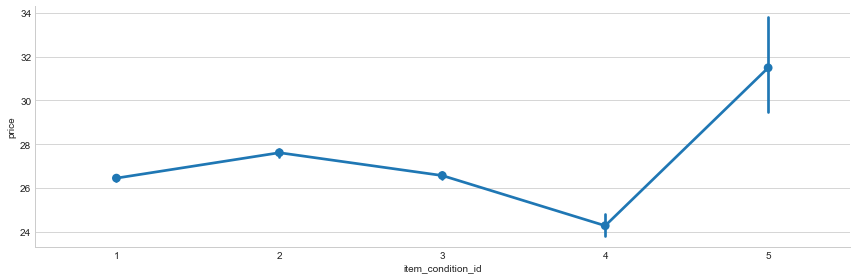

In [3]:
sns.factorplot('item_condition_id','price', data=train_df,size=4,aspect=3)

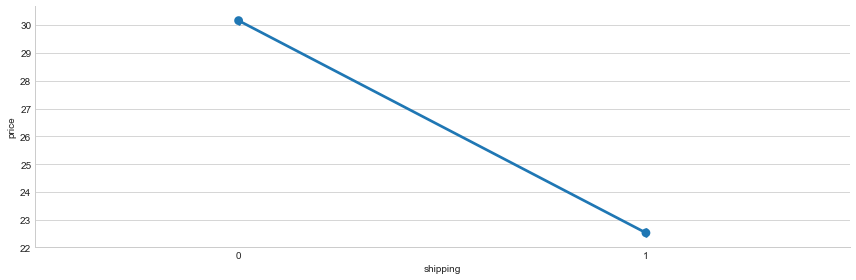

In [4]:
sns.factorplot('shipping','price', data=train_df,size=4,aspect=3)

count    741268.000000
mean         26.746921
std          38.610357
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        2009.000000
Name: price, dtype: float64

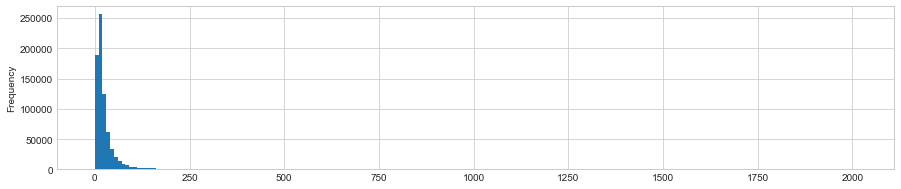

In [16]:
train_df['price'].plot(kind='hist', figsize=(15,3),bins=200)
train_df.price.describe()

In [38]:
print (train_df['category_name'].value_counts()[:5])

def split_category_name(text):
    try:
        return text.split("/")
    except:
        return (np.nan, np.nan, np.nan)
    
train_df['general_cat'], train_df['subcat_1'], train_df['subcat_2'] = \
zip(*train_df['category_name'].apply(lambda x: split_category_name(x)))

train_df.head()

Women/Athletic Apparel/Pants, Tights, Leggings    30094
Women/Tops & Blouses/T-Shirts                     23443
Beauty/Makeup/Face                                17221
Beauty/Makeup/Lips                                14755
Electronics/Video Games & Consoles/Games          13303
Name: category_name, dtype: int64


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
724109,724109,New mini makeup and full sized blush,2,Beauty/Makeup/Makeup Sets,Pop Beauty,13.0,1,"1 Nyx cream blush, one mini Elizabeth Mott mas...",Beauty,Makeup,Makeup Sets
12830,12830,VS bathing JUST THE TOP!,3,Women/Swimwear/Two-Piece,Victoria's Secret,14.0,1,Only worn once! Top is a 32d and bottoms are a...,Women,Swimwear,Two-Piece
1098486,1098486,Kawaii bundle for Kawaii=^.^=Love,1,Handmade/Paper Goods/Stationery,NaN,39.0,0,Bundle includes 3 Memo Pads and letter set MOC...,Handmade,Paper Goods,Stationery
1433123,1433123,Authentic Marvel Deadpool X-Force Wallet,1,Men/Men's Accessories/Wallets,Marvel,16.0,1,This is for brand new authentic Marvel Deadpoo...,Men,Men's Accessories,Wallets
103591,103591,XXS holiday forest green Irma NWT,1,Women/Tops & Blouses/Tunic,NaN,38.0,1,Last photo is an accurate pic of color!! Perfe...,Women,Tops & Blouses,Tunic


Women          332158
Beauty         103845
Kids            85791
Electronics     61433
Men             46970
Name: general_cat, dtype: int64
There are 10 unique first sub-categories.
There are 113 unique first sub-categories.
There are 839 unique first sub-categories.


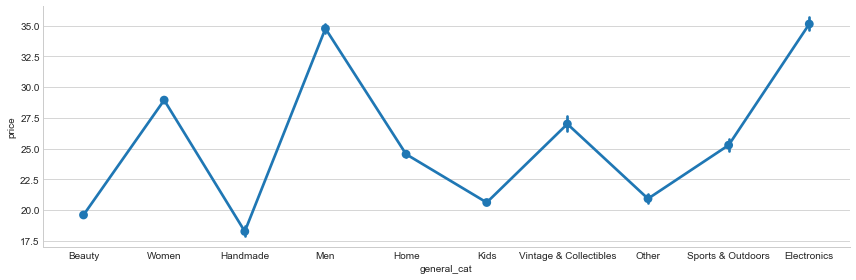

In [42]:
print (train_df['general_cat'].value_counts()[:5])
sns.factorplot('general_cat','price', data=train_df,size=4,aspect=3)

print("There are %d unique first sub-categories." % train_df['general_cat'].nunique())
print("There are %d unique first sub-categories." % train_df['subcat_1'].nunique())
print("There are %d unique first sub-categories." % train_df['subcat_2'].nunique())

In [8]:
# X_train = train_df.drop(['train_id','name','category_name','brand_name','price','item_description'],axis=1)
# Y_train = train_df['price']

# X_train, X_validation, Y_train, Y_validation = train_test_split(
#     X_train, Y_train, test_size=0.2, random_state=random_seed)

# lr = LinearRegression()
# lr.fit(X_train, Y_train)
# Y_validation_pred = lr.predict(X_validation)

# rmsle_error = np.sqrt(np.square(np.log(Y_validation_pred + 1) 
#                                 - np.log(Y_validation + 1) ).mean())
# print (rmsle_error)

In [9]:
# X_test  = test_df.drop(['test_id','name','category_name','brand_name','item_description'],axis=1)
# Y_pred = lr.predict(X_test)
# sub = pd.DataFrame({
#         "test_id": test_df["test_id"],
#         "price": Y_pred
# })

# sub.to_csv('sub.csv', index = False)